# Functional anomaly detection

Anomaly detection (or outlier detection) comprises the machine learning methods aimed at identification of observations that exhibit suspicious behaviour and are very likely to cause a problem. In the unsupervised learning framework, no label indicating whether a training observation is anomalous or not is available. Hence, anomalies should be identified in an automatic way by learning the normal behavior, that of the vast majority of the observations, and considering those differing significantly from it as abnormal. Logically, anomalies are rare in the data and thus fall in low density regions: anomaly detection thus boils down to identifying the tail of the distribution.

With the ubiquitous deployment of sensors monitoring nearly continuously the health of complex infrastructures, anomaly detection can now rely on measurements sampled at a very high frequency, providing a very rich representation of the phenomenon under surveillance. In order to exploit fully the collected information, the observations cannot be treated as multivariate data anymore and a functional analysis approach is required.

A (very) short list of literature regarding functional anomaly detection can include:

- J.O. Ramsay, Silverman, B.W. (2005): Functional Data Analysis. Springer-Verlag, New-York.
- Ferraty, F., Vieu, P. (2006): Nonparametric Functional Data Analysis: Theory and Practice. Springer Science & Business Media.
- Chandola, V., Banerjee, A., Kumar, V. (2009): Anomaly detection: A survey. ACM Computing Surveys (CSUR) 41(3), 1-58.
- Hubert, M., Rousseeuw, P.J., Segaert, P. (2015): Multivariate functional outlier detection. Statistical Methods & Applications - 24(2), 177-202.
- Wang, J.L., Chiou, J.M., Müller, H.G. (2016): Functional data analysis. Annual Review of Statistics and Its Application 3, 257-295.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import pandas as pd
import sys
import pickle
import tsfresh
from tsfresh import extract_features

from pathlib import Path
from datetime import datetime

project_path = Path().cwd().parent.parent
data_path = project_path / 'data'
src_path = project_path / 'python' / 'src'
model_path = project_path / 'model'

sys.path.append(str(src_path))

from viz import plot_clustering
from utils import EarlyStopping, ModelManagement, PlotLoss, train, loss_function
from model import DenseAutoencoder, VRAE

## Dataset

The data set is provided by the Airbus and consistst of the measures of the accelerometer of helicopters during 1 minute at frequency 1024 Hertz, which yields time series measured at in total 60 * 1024 = 61440 equidistant time points.

__Training data__:

The training set consists of one file, airbus_train.csv. File airbus_train.csv contains one observation per row, each observation having 61440 entries, measures with equivalent time distance of 1 / 1024 seconds. There are in total 1677 training observations.

__Test data__:

The training set consists of one file, airbus_test.csv, which has the same structure as file airbus_train.csv. There are in total 2511 test observations.

## Exploration

### Data

In [2]:
X_train = np.loadtxt(data_path / 'airbus_train.csv', delimiter= ' ')
print('Train shape', X_train.shape)
X_test = np.loadtxt(data_path / 'airbus_test.csv', delimiter= ' ')
print('Test shape', X_test.shape)

Train shape (1677, 61440)
Test shape (2511, 61440)


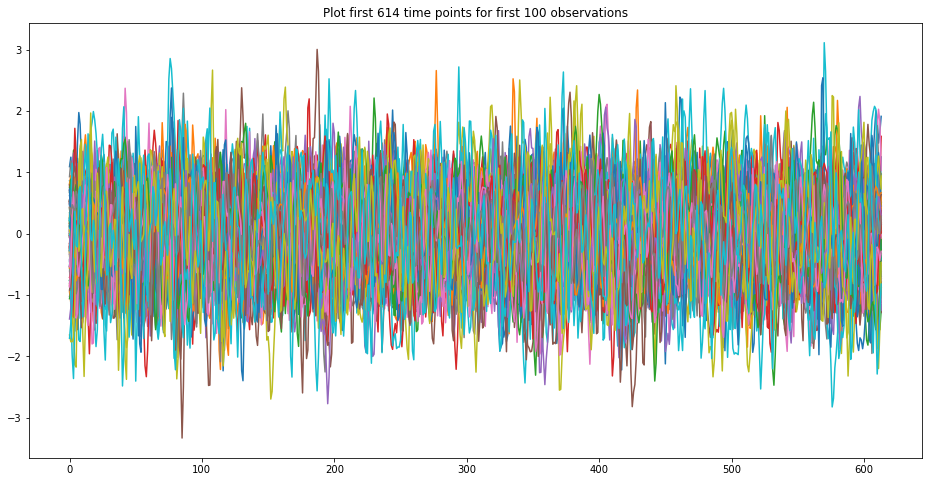

In [3]:
plt.figure(figsize=(16,8))
for i in range(100):
    plt.plot(range(614),X_train[i,:614])

title = 'Plot first 614 time points for first 100 observations'
_ = plt.title(title)

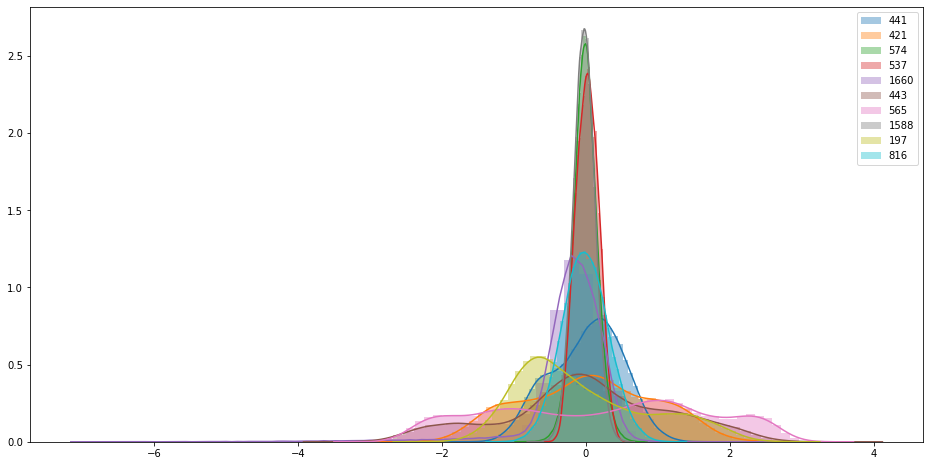

In [4]:
nb_dist = 10
indices = np.random.randint(low=0, high=X_train.shape[0], size=10)

plt.figure(figsize=(16,8))
for idx in indices:
    sns.distplot(X_train[idx, :])

_ = plt.legend(indices)

In [3]:
def standardize(array):
    for i in range(array.shape[0]):
        if array[i, :].std():
            mean = array[i, :].mean()
            std = array[i, :].std()
            array[i, :] =  (array[i, :] - mean)/std
    return array

X_train_rescaled = standardize(X_train.copy())
X_test_rescaled = standardize(X_test.copy())

The time series' lenght is too long with a lot of noise. We need to reduce the size by extracting some interesting features. To do that, we create a sliding window of 0.5s and compute the mean of the values inside along each time series.

We prefer the mean because this statistic is less robust against the outlier. In order to apply anomaly detection, we need to find the outliers in the dataset.

In [4]:
df_X_train = pd.DataFrame(X_train_rescaled).T
df_X_train.index = pd.to_timedelta(np.arange(0, 60, 1/1024), unit='s')
df_train_resample_mean = df_X_train.resample('0.06S').mean()
print('Shape of the resampled train dataset: ', df_train_resample_mean.shape)

df_X_test = pd.DataFrame(X_test_rescaled).T
df_X_test.index = pd.to_timedelta(np.arange(0, 60, 1/1024), unit='s')
df_test_resample_mean = df_X_test.resample('0.06S').mean()
print('Shape of the resampled train dataset: ', df_test_resample_mean.shape)

Shape of the resampled train dataset:  (1000, 1677)
Shape of the resampled train dataset:  (1000, 2511)


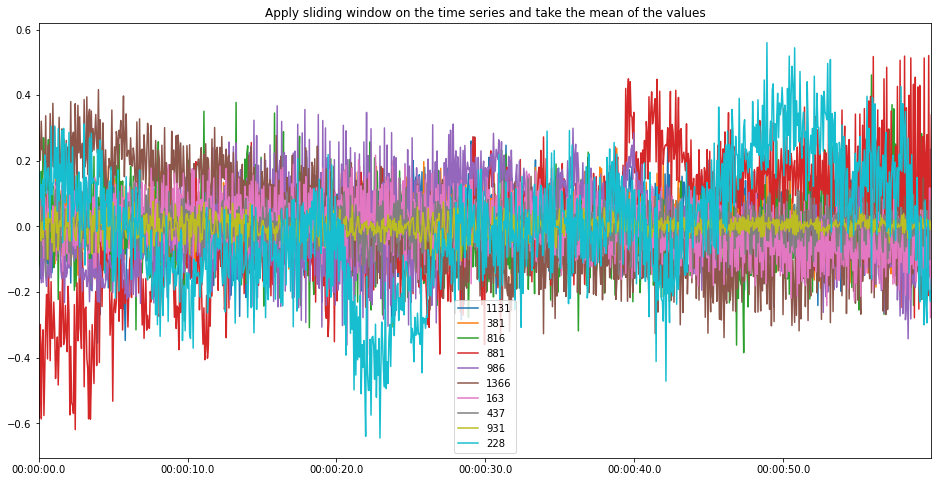

In [13]:
indices = np.random.randint(low=0, high=X_train.shape[0], size=10)

df_train_resample_mean.iloc[:, indices].plot(figsize=(16,8))

title = 'Apply sliding window on the time series and take the mean of the values'
_ = plt.title(title)

Let's visualize the series in the Fourier domain.

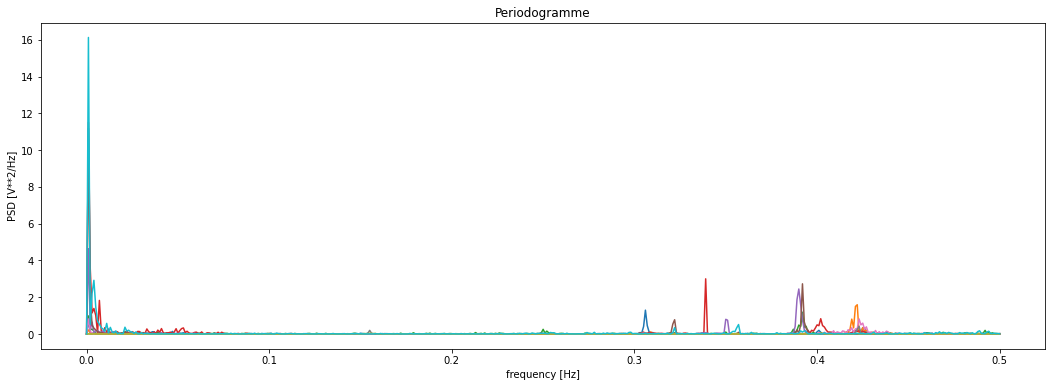

In [15]:
plt.figure(1, figsize=(18, 6))
for i in indices:
    obs = df_train_resample_mean.T.values[i, :]
    f, Pxx_den = signal.periodogram(obs)
    plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
_ = plt.title('Periodogramme')

### Approches

As we work with time series, The challenge can be tackled through two angles :
- Frequencial domain
- Temporal domain

__Frequencial domain__

Methods based on Continuous Wavelet Transform (CWT) could be effective. They can extract relevant information located in the frequencial domain and then create an 2D image of the time serie called scalogram. This image can be used as features to a classifier such as neural network.

__Temporal domain__

Other approches used directly the time series in de temporal domain.

In this notebook, I decided to use an approch based on autoencoders. Autoencoder can be used to detect anomalies by reducing the dimensionality of the data and by projecting it on a lower space, i.e., latent space, where more correlated variables remain. The main assumption about the distribution of data is the fact that normal and abnormal data are significantly different on this space, which the definition of anomalies implies. Then, projecting back to the original space will show significant differences
in some data points, which represent the anomalous data instances.

## Features extraction

### Train

`tsfresh` is a python package used to extract characteristics from time series.

In [6]:
df_X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676
00:00:00,0.075704,-0.309755,0.236218,-1.101421,-1.608258,1.454749,-1.353250,0.008020,0.008917,0.089035,...,0.304923,-1.557359,0.665773,-0.711695,1.615789,-0.247801,2.656970,1.241558,1.567564,0.756235
00:00:00.000976,0.075704,-0.386245,0.166789,-0.914797,-1.446060,1.376056,-0.940343,-0.000438,0.031555,0.128294,...,-0.560851,-1.946843,0.810236,-0.686275,1.353687,0.096837,1.969828,0.587812,1.505721,-2.266754
00:00:00.001953,-0.272875,-0.400295,0.145329,-1.534397,-1.080288,1.000294,-0.509865,-0.003258,-0.128537,1.050830,...,0.816763,-1.989173,-0.268335,0.410519,1.214927,0.091613,0.981094,-0.334979,1.199451,-2.266754
00:00:00.002929,-0.621454,-0.345658,0.001422,-1.997232,-0.752581,0.703227,-0.742674,0.072867,-0.063853,0.638637,...,1.342218,-1.726700,-0.297219,1.216765,1.712153,-1.339159,0.838071,-0.971124,0.421995,0.472823
00:00:00.003906,-0.403622,-0.230144,-0.060434,-2.101745,-0.552316,0.323530,-0.189201,0.036215,0.220757,-0.571789,...,1.589969,-0.380441,0.829499,0.704697,2.355845,-2.111985,1.478572,-1.290455,-1.015119,1.795337


In [7]:
data = df_train_resample_mean

In [8]:
# Get the name of candidate featues
ts = data.reset_index().loc[:, ['index', 0]]\
        .rename(columns={'index': 'time', 0: 'values'})\
        .reset_index()
n_observations_train = data.shape[1]

extracted_features = extract_features(ts, column_id="index", column_sort="time")
features_name = [col for col, item in extracted_features.iteritems() if item.unique().shape[0] > 5]

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


In [23]:
features_selected = set(np.random.choice(features_name, 5))
extracted_features_filtered = extracted_features.loc[:, features_selected]

In [24]:
features_selected

{'values__abs_energy',
 'values__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
 'values__fft_coefficient__coeff_0__attr_"real"',
 'values__quantile__q_0.2',
 'values__quantile__q_0.9'}

In [25]:
# we can easily construct the corresponding settings object
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(extracted_features_filtered)
kind_to_fc_parameters = {str(col): kind_to_fc_parameters['values'] for col in range(n_observations_train)}

In [26]:
# Get the name of candidate featues
ts = data.reset_index()\
        .rename(columns={'index': 'time'})\
        .reset_index()

extracted_features = extract_features(ts, column_id="index",
                                      column_sort="time",
                                      n_jobs=4, kind_to_fc_parameters=kind_to_fc_parameters)

Feature Extraction: 100%|██████████| 20/20 [12:25<00:00, 37.28s/it]


In [27]:
extracted_features.head()

variable,0__abs_energy,"0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","0__fft_coefficient__coeff_0__attr_""real""",0__quantile__q_0.2,0__quantile__q_0.9,1000__abs_energy,"1000__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","1000__fft_coefficient__coeff_0__attr_""real""",1000__quantile__q_0.2,1000__quantile__q_0.9,...,99__abs_energy,"99__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","99__fft_coefficient__coeff_0__attr_""real""",99__quantile__q_0.2,99__quantile__q_0.9,9__abs_energy,"9__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","9__fft_coefficient__coeff_0__attr_""real""",9__quantile__q_0.2,9__quantile__q_0.9
id,,,,,,,,,,,,,,,,,,,,,
0,0.011157,-0.028970,-0.105626,-0.105626,-0.105626,0.341785,-0.160346,-0.584624,-0.584624,-0.584624,...,0.041585,-0.055931,-0.203924,-0.203924,-0.203924,0.001409,0.010296,0.037539,0.037539,0.037539
1,0.003107,-0.015289,-0.055743,-0.055743,-0.055743,0.027408,-0.045407,-0.165554,-0.165554,-0.165554,...,0.003078,-0.015217,-0.055482,-0.055482,-0.055482,0.001652,-0.011146,-0.040640,-0.040640,-0.040640
2,0.014223,0.032710,0.119261,0.119261,0.119261,0.124594,-0.096812,-0.352979,-0.352979,-0.352979,...,0.001809,0.011667,0.042537,0.042537,0.042537,0.001110,0.009138,0.033318,0.033318,0.033318
3,0.000005,-0.000595,-0.002169,-0.002169,-0.002169,0.020913,0.039664,0.144615,0.144615,0.144615,...,0.010136,-0.027612,-0.100675,-0.100675,-0.100675,0.005830,-0.020943,-0.076357,-0.076357,-0.076357
4,0.000020,-0.001214,-0.004427,-0.004427,-0.004427,0.115787,0.093328,0.340275,0.340275,0.340275,...,0.017534,-0.036318,-0.132416,-0.132416,-0.132416,0.003776,-0.016853,-0.061448,-0.061448,-0.061448


In [33]:
extracted_features.to_csv(data_path / 'extracted_features_train.csv')
with open(data_path / 'kind_to_fc_parameters.pkl', 'wb') as f:
    pickle.dump(kind_to_fc_parameters, f)

In [11]:
features_selected = ['values__abs_energy',
 'values__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
 'values__fft_coefficient__coeff_0__attr_"real"',
 'values__quantile__q_0.2',
 'values__quantile__q_0.9']

In [27]:
features_selected = [col.replace('values__', '') for col in features_selected]

In [23]:
extracted_features_train.head()

,0__abs_energy,"0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","0__fft_coefficient__coeff_0__attr_""real""",0__quantile__q_0.2,0__quantile__q_0.9,1000__abs_energy,"1000__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","1000__fft_coefficient__coeff_0__attr_""real""",1000__quantile__q_0.2,1000__quantile__q_0.9,...,99__abs_energy,"99__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","99__fft_coefficient__coeff_0__attr_""real""",99__quantile__q_0.2,99__quantile__q_0.9,9__abs_energy,"9__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","9__fft_coefficient__coeff_0__attr_""real""",9__quantile__q_0.2,9__quantile__q_0.9
0,0.011157,-0.028970,-0.105626,-0.105626,-0.105626,0.341785,-0.160346,-0.584624,-0.584624,-0.584624,...,0.041585,-0.055931,-0.203924,-0.203924,-0.203924,0.001409,0.010296,0.037539,0.037539,0.037539
1,0.003107,-0.015289,-0.055743,-0.055743,-0.055743,0.027408,-0.045407,-0.165554,-0.165554,-0.165554,...,0.003078,-0.015217,-0.055482,-0.055482,-0.055482,0.001652,-0.011146,-0.040640,-0.040640,-0.040640
2,0.014223,0.032710,0.119261,0.119261,0.119261,0.124594,-0.096812,-0.352979,-0.352979,-0.352979,...,0.001809,0.011667,0.042537,0.042537,0.042537,0.001110,0.009138,0.033318,0.033318,0.033318
3,0.000005,-0.000595,-0.002169,-0.002169,-0.002169,0.020913,0.039664,0.144615,0.144615,0.144615,...,0.010136,-0.027612,-0.100675,-0.100675,-0.100675,0.005830,-0.020943,-0.076357,-0.076357,-0.076357
4,0.000020,-0.001214,-0.004427,-0.004427,-0.004427,0.115787,0.093328,0.340275,0.340275,0.340275,...,0.017534,-0.036318,-0.132416,-0.132416,-0.132416,0.003776,-0.016853,-0.061448,-0.061448,-0.061448


### Test

In [12]:
# we can easily construct the corresponding settings object
data = df_test_resample_mean
n_observations_test = data.shape[1]
kind_to_fc_parameters_1 = {str(col): kind_to_fc_parameters['0'] for col in range(1000)}
kind_to_fc_parameters_2 = {str(col): kind_to_fc_parameters['0'] for col in range(998,1998)}
kind_to_fc_parameters_3 = {str(col): kind_to_fc_parameters['0'] for col in range(1998-2,n_observations_test)}

In [13]:
# Get the name of candidate featues
ts = data.reset_index()\
        .rename(columns={'index': 'time'})\
        .reset_index()

extracted_features_1 = extract_features(ts.iloc[:, :1000], column_id="index",
                                      column_sort="time",
                                      n_jobs=4, kind_to_fc_parameters=kind_to_fc_parameters_1)
extracted_features_2 = extract_features(ts.iloc[:, [0, 1]+ list(range(998,1998))], column_id="index",
                                      column_sort="time",
                                      n_jobs=4, kind_to_fc_parameters=kind_to_fc_parameters_2)
extracted_features_3 = extract_features(ts.iloc[:, [0, 1]+ list(range(1998-2,n_observations_test+2))], column_id="index",
                                      column_sort="time",
                                      n_jobs=4, kind_to_fc_parameters=kind_to_fc_parameters_3)

Feature Extraction: 100%|██████████| 20/20 [03:56<00:00, 11.81s/it]


In [14]:
extracted_features = pd.concat([extracted_features_1, extracted_features_2, extracted_features_3],
                               axis=1)

In [15]:
extracted_features.to_csv(data_path / 'extracted_features_test.csv')
with open(data_path / 'kind_to_fc_parameters_test.pkl', 'wb') as f:
    pickle.dump(kind_to_fc_parameters, f)

In [54]:
extracted_features_test.head()

,0__abs_energy,"0__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","0__fft_coefficient__coeff_0__attr_""real""",0__quantile__q_0.2,0__quantile__q_0.9,100__abs_energy,"100__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","100__fft_coefficient__coeff_0__attr_""real""",100__quantile__q_0.2,100__quantile__q_0.9,...,2509__abs_energy,"2509__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","2509__fft_coefficient__coeff_0__attr_""real""",2509__quantile__q_0.2,2509__quantile__q_0.9,2510__abs_energy,"2510__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10","2510__fft_coefficient__coeff_0__attr_""real""",2510__quantile__q_0.2,2510__quantile__q_0.9
0,24.345641,1.353295,4.934130,4.934130,4.934130,0.021544,0.040257,0.146778,0.146778,0.146778,...,0.000035,0.001625,0.005924,0.005924,0.005924,0.011196,-0.029021,-0.105810,-0.105810,-0.105810
1,22.739583,1.307896,4.768604,4.768604,4.768604,0.567663,0.206646,0.753434,0.753434,0.753434,...,0.025788,0.044044,0.160585,0.160585,0.160585,0.004886,-0.019171,-0.069899,-0.069899,-0.069899
2,25.849146,1.394457,5.084206,5.084206,5.084206,0.030909,0.048219,0.175808,0.175808,0.175808,...,0.087278,-0.081028,-0.295429,-0.295429,-0.295429,0.007322,0.023469,0.085569,0.085569,0.085569
3,22.048738,1.287875,4.695608,4.695608,4.695608,0.252741,0.137886,0.502733,0.502733,0.502733,...,0.035196,-0.051455,-0.187606,-0.187606,-0.187606,0.007054,0.023035,0.083986,0.083986,0.083986
4,25.447528,1.383581,5.044554,5.044554,5.044554,0.330205,0.157606,0.574635,0.574635,0.574635,...,0.167698,-0.112317,-0.409509,-0.409509,-0.409509,0.016950,-0.035708,-0.130194,-0.130194,-0.130194


## Anomalies detection

### Dense Autoencoder

__Learning__

In [166]:
train_loader = torch.utils.data.DataLoader(dataset=df_train_resample_mean.T.values.reshape(((1677, 1000))), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=df_test_resample_mean.T.values.reshape((2511, 1000)), batch_size=32, shuffle=False)

Train Epoch: 1 [1/53 (2%)]	Loss: 0.017549
Train Epoch: 1 [26/53 (49%)]	Loss: 0.009071
Train Epoch: 1 [51/53 (96%)]	Loss: 0.007390
====> Epoch: 1 Average loss: 0.0099
Train Epoch: 2 [1/53 (2%)]	Loss: 0.005738
Train Epoch: 2 [26/53 (49%)]	Loss: 0.004739
Train Epoch: 2 [51/53 (96%)]	Loss: 0.005195
====> Epoch: 2 Average loss: 0.0053
Train Epoch: 3 [1/53 (2%)]	Loss: 0.003452
Train Epoch: 3 [26/53 (49%)]	Loss: 0.003855
Train Epoch: 3 [51/53 (96%)]	Loss: 0.003559
====> Epoch: 3 Average loss: 0.0040
Train Epoch: 4 [1/53 (2%)]	Loss: 0.002911
Train Epoch: 4 [26/53 (49%)]	Loss: 0.004374
Train Epoch: 4 [51/53 (96%)]	Loss: 0.002711
====> Epoch: 4 Average loss: 0.0037
Train Epoch: 5 [1/53 (2%)]	Loss: 0.003338
Train Epoch: 5 [26/53 (49%)]	Loss: 0.003654
Train Epoch: 5 [51/53 (96%)]	Loss: 0.002782
====> Epoch: 5 Average loss: 0.0033
Train Epoch: 6 [1/53 (2%)]	Loss: 0.002172
Train Epoch: 6 [26/53 (49%)]	Loss: 0.002848
Train Epoch: 6 [51/53 (96%)]	Loss: 0.003180
====> Epoch: 6 Average loss: 0.0031
Trai

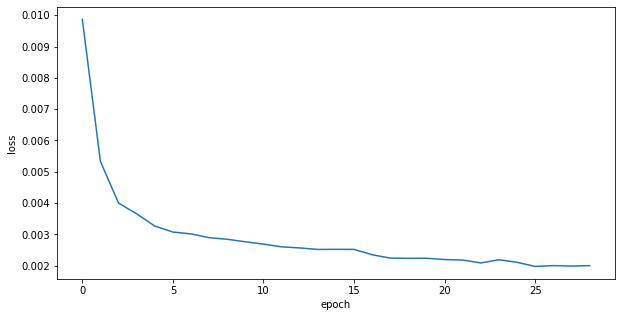

In [167]:
name_model = 'dense_autoencoder'
epochs = 30

model = DenseAutoencoder(x_dim=1000, h_dim1=512, h_dim2=256, z_dim=2)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

callbacks = {'model_management': ModelManagement(str(model_path), name_model),
            'plot_loss': PlotLoss(),
            'early_stopping': EarlyStopping(patience=5)}

for epoch in range(1, epochs):
    if train(model, train_loader, epoch, optimizer, callbacks):
        break
        
callbacks['model_management'].save(model)
callbacks['plot_loss'].plot()

__Prediction__

First, I use the dense autoencoder as a projection into a low dimension space of the data. After training the network with the train dataset, I use it to obtain a low space representation of the test dataset. Then, I apply an isolation forest to find anomalies.

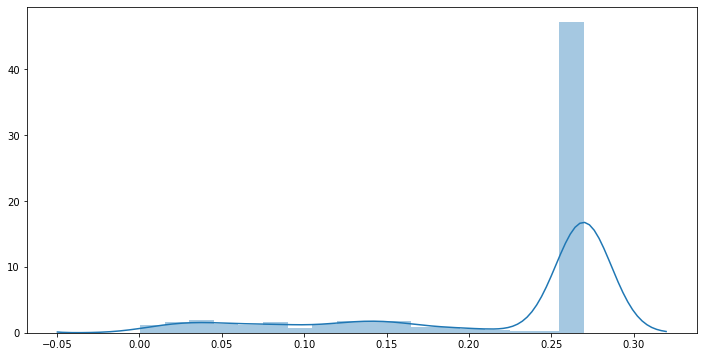

In [223]:
data = torch.from_numpy(test_loader.dataset).float().to(device)
latent = model.encoder(data)
latent = latent.detach().to('cpu')

clf = IsolationForest(contamination=0.08, n_estimators=100).fit(latent)

score = np.abs(clf.decision_function(latent))

plt.figure(1, figsize=(12, 6))
sns.distplot(score)

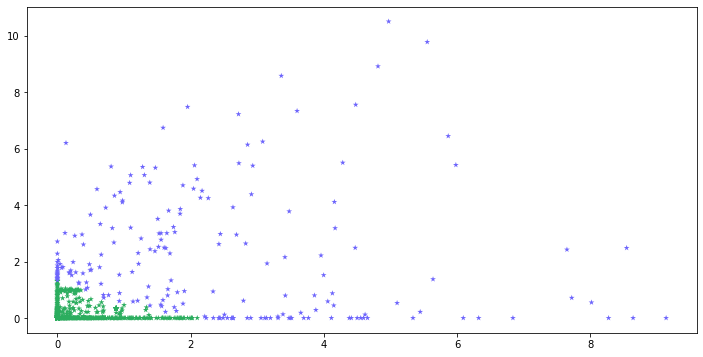

In [224]:
labels = clf.predict(latent)
labels[labels == -1] = 0
labels = labels[:latent.shape[0]] # because of weird batch_size

hex_colors = []
for _ in np.unique(labels):
    hex_colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))

colors = [hex_colors[int(i)] for i in labels]

plt.figure(1, figsize=(12, 6))
plt.scatter(latent[:, 0], latent[:, 1], c=colors, marker='*', linewidths=0)

By looking to the plot, we can see that the points are mostly located on two straight lines. The points which diverge from these two lines may be anomalies. The Dense Autoencoder did not succed to understand the information.

In [191]:
from datetime import datetime

date = str(datetime.now()).replace(' ', '_')

np.savetxt(data_path / f'submission_{date}.csv', score, fmt = '%1.6f', delimiter=',')

### Convolutionnal autoencoder

__Learning__

In [225]:
bs = 32

train_loader = torch.utils.data.DataLoader(dataset=df_train_resample_mean.T.values.reshape(((1677, 1000, 1))), batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=df_test_resample_mean.T.values.reshape(((2511, 1000, 1))), batch_size=bs, shuffle=False)

In [226]:
class Encoder(nn.Module):
    def __init__(self, kernel_size=5, factor=5):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1000, out_channels=128,
                               kernel_size=kernel_size, padding=(kernel_size // 2))
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=10,
                               kernel_size=kernel_size, padding=(kernel_size // 2))
        self.batch_norm2 = nn.BatchNorm1d(10)
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=2,
                               kernel_size=kernel_size, padding=(kernel_size // 2))
        self.batch_norm3 = nn.BatchNorm1d(2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, factor=5, kernel_size=5):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(in_channels=2, out_channels=10,
                                         kernel_size=kernel_size, padding=(kernel_size // 2))
        self.batch_norm1 = nn.BatchNorm1d(10)
        self.deconv2 = nn.ConvTranspose1d(in_channels=10, out_channels=128,
                                         kernel_size=kernel_size, padding=(kernel_size // 2))
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.deconv3 = nn.ConvTranspose1d(in_channels=128, out_channels=1000,
                                         kernel_size=kernel_size, padding=(kernel_size // 2))
        self.batch_norm3 = nn.BatchNorm1d(1000)
    
    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = self.batch_norm1(x)
        x = F.relu(self.deconv2(x))
        x = self.batch_norm2(x)
        x = F.relu(self.deconv3(x))
        x = self.batch_norm3(x)
        return x  

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder(seq_len=3809, n_features=1, factor=1)

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

Train Epoch: 1 [1/53 (2%)]	Loss: 0.033012
Train Epoch: 1 [26/53 (49%)]	Loss: 0.023508
Train Epoch: 1 [51/53 (96%)]	Loss: 0.017736
====> Epoch: 1 Average loss: 0.0243
Train Epoch: 2 [1/53 (2%)]	Loss: 0.016482
Train Epoch: 2 [26/53 (49%)]	Loss: 0.012125
Train Epoch: 2 [51/53 (96%)]	Loss: 0.009444
====> Epoch: 2 Average loss: 0.0125
Train Epoch: 3 [1/53 (2%)]	Loss: 0.008064
Train Epoch: 3 [26/53 (49%)]	Loss: 0.006306
Train Epoch: 3 [51/53 (96%)]	Loss: 0.004732
====> Epoch: 3 Average loss: 0.0064
Train Epoch: 4 [1/53 (2%)]	Loss: 0.004106
Train Epoch: 4 [26/53 (49%)]	Loss: 0.003184
Train Epoch: 4 [51/53 (96%)]	Loss: 0.002677
====> Epoch: 4 Average loss: 0.0034
Train Epoch: 5 [1/53 (2%)]	Loss: 0.002773
Train Epoch: 5 [26/53 (49%)]	Loss: 0.002931
Train Epoch: 5 [51/53 (96%)]	Loss: 0.001438
====> Epoch: 5 Average loss: 0.0021
Train Epoch: 6 [1/53 (2%)]	Loss: 0.001776
Train Epoch: 6 [26/53 (49%)]	Loss: 0.001229
Train Epoch: 6 [51/53 (96%)]	Loss: 0.001646
====> Epoch: 6 Average loss: 0.0017
Trai

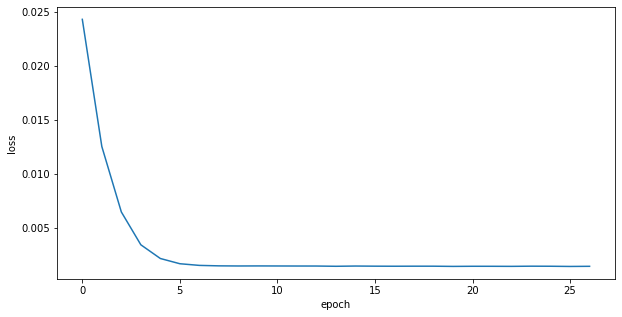

In [227]:
name_model = 'exploration_model'

model = ConvAutoencoder()
model = model.to(device)
epochs = 40

optimizer = optim.Adam(model.parameters(), lr=0.005)

callbacks = {'model_management': ModelManagement(str(model_path), name_model),
            'plot_loss': PlotLoss(),
            'early_stopping': EarlyStopping(patience=5)}

for epoch in range(1, epochs):
    if train(model, train_loader, epoch, optimizer, callbacks):
        break
        
callbacks['model_management'].save(model)
callbacks['plot_loss'].plot()

In [228]:
def encode(model, data_loader):
    with torch.no_grad():
        x_decoded = []

        for t, x in enumerate(data_loader):
            x = x.to(device)

            x_decoded_each = model.encoder.forward(x.float())
            x_decoded.append(x_decoded_each.to('cpu'))

    return np.vstack(x_decoded).reshape(data_loader.dataset.shape[0], 2)

def get_anomaly_score(model, data_loader):
    with torch.no_grad():
        losses = []

        for t, x in enumerate(data_loader):
            x = x.to(device)

            x_decoded_each = model.forward(x.float())
            losses += [loss_function(x[i, :, :], x_decoded_each[i, :, :]).to('cpu') for i in range(x.shape[0])]
    return np.array(losses)

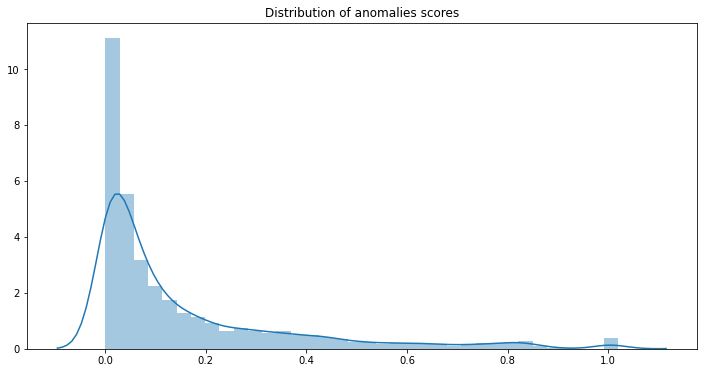

In [229]:
losses = get_anomaly_score(model, test_loader)

plt.figure(1, figsize=(12, 6))
sns.distplot(losses)
_ = plt.title('Distribution of anomalies scores')

In [245]:
labels = np.zeros(losses.shape)
labels[losses > 0.2] = 1

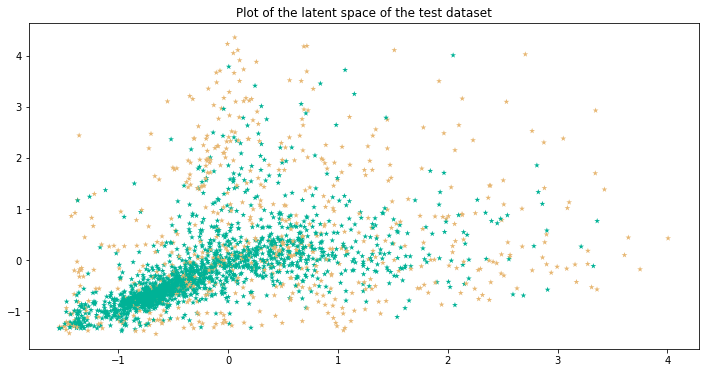

In [249]:
latent = encode(model, test_loader)

hex_colors = []
for _ in np.unique(labels):
    hex_colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))

colors = [hex_colors[int(i)] for i in labels]

plt.figure(1, figsize=(12, 6))
plt.scatter(latent[:, 0], latent[:, 1], c=colors, marker='*', linewidths=0)
_ = plt.title('Plot of the latent space of the test dataset')

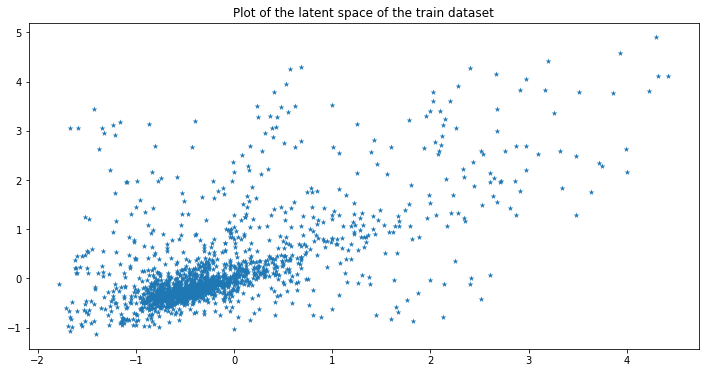

In [164]:
latent = encode(model, train_loader)

plt.figure(1, figsize=(12, 6))
plt.scatter(latent[:, 0], latent[:, 1], marker='*', linewidths=0)
_ = plt.title('Plot of the latent space of the train dataset')

In [243]:
from datetime import datetime

date = str(datetime.now()).replace(' ', '_')

np.savetxt(data_path / f'submission_{date}.csv', score, fmt = '%1.6f', delimiter=',')

### LSTM

In [250]:
features_selected = ['values__abs_energy',
 'values__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
 'values__fft_coefficient__coeff_0__attr_"real"',
 'values__quantile__q_0.2',
 'values__quantile__q_0.9']

features_selected = [col.replace('values__', '') for col in features_selected]

In [251]:
# Get features for train dataset
extracted_features_train = pd.read_csv(data_path / 'extracted_features_train.csv', index_col=False).drop(columns='id')
with open(data_path / 'kind_to_fc_parameters.pkl', 'rb') as f:
    kind_to_fc_parameters = pickle.load(f)

In [252]:
# Get features for test dataset
extracted_features_test = pd.read_csv(data_path / 'extracted_features_test.csv', index_col=False).drop(columns='id')
with open(data_path / 'kind_to_fc_parameters.pkl', 'rb') as f:
    kind_to_fc_parameters = pickle.load(f)

In [284]:
# number_of_features = len(features_selected)+1
number_of_features = 1

lenght_seq, n_seq =  df_train_resample_mean.shape
train_data = np.zeros((n_seq, lenght_seq, number_of_features))
train_data[:, :, 0] += df_train_resample_mean.T.values.reshape(n_seq, lenght_seq)

# for idx, feature_name in enumerate(features_selected):
#     features_train = pd.DataFrame(range(1000))
#     for col in range(n_seq):
#         features_train[col] = extracted_features_train.loc[:, f'{col}__{feature_name}']
#     train_data[:, :, idx+1] += features_train.T.values.reshape(n_seq, lenght_seq)
    
train_dataset = TensorDataset(torch.from_numpy(train_data))

lenght_seq, n_seq =  df_test_resample_mean.shape
test_data = np.zeros((n_seq, lenght_seq, number_of_features))
test_data[:, :, 0] += df_test_resample_mean.T.values.reshape(n_seq, lenght_seq)

# for idx, feature_name in enumerate(features_selected):
#     features_test = pd.DataFrame(range(1000))
#     for col in range(n_seq):
#         features_test[col] = extracted_features_test.loc[:, f'{col}__{feature_name}']
#     test_data[:, :, idx+1] += features_test.T.values.reshape(n_seq, lenght_seq)
    
test_data = np.vstack([test_data, np.zeros((17, lenght_seq, number_of_features))])
test_dataset = TensorDataset(torch.from_numpy(test_data))

In [295]:
hidden_size = 60
hidden_layer_depth = 1
latent_length = 2
batch_size = 32
learning_rate = 0.002
n_epochs = 20
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'SmoothL1Loss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

In [296]:
sequence_length = train_dataset.tensors[0].shape[1]

In [297]:
autoencoder = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = str(model_path))

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [298]:
autoencoder.fit(train_dataset)

Epoch: 0
Batch 30, loss = 929.8076, recon_loss = 929.8016, kl_loss = 0.0060
Average loss: 812.1891
Epoch: 1
Batch 30, loss = 725.2896, recon_loss = 725.2731, kl_loss = 0.0165
Average loss: 809.9869
Epoch: 2
Batch 30, loss = 610.7083, recon_loss = 610.7078, kl_loss = 0.0005
Average loss: 805.4818
Epoch: 3
Batch 30, loss = 780.1071, recon_loss = 780.1060, kl_loss = 0.0010
Average loss: 810.6198
Epoch: 4
Batch 30, loss = 803.3779, recon_loss = 803.3773, kl_loss = 0.0006
Average loss: 808.8000
Epoch: 5
Batch 30, loss = 746.1859, recon_loss = 746.1858, kl_loss = 0.0001
Average loss: 807.3196
Epoch: 6
Batch 30, loss = 523.0573, recon_loss = 523.0518, kl_loss = 0.0055
Average loss: 806.8777
Epoch: 7
Batch 30, loss = 712.1270, recon_loss = 712.1265, kl_loss = 0.0004
Average loss: 811.3786
Epoch: 8
Batch 30, loss = 507.2305, recon_loss = 507.2295, kl_loss = 0.0010
Average loss: 812.7153
Epoch: 9
Batch 30, loss = 776.7744, recon_loss = 776.7737, kl_loss = 0.0007
Average loss: 810.1071
Epoch: 10


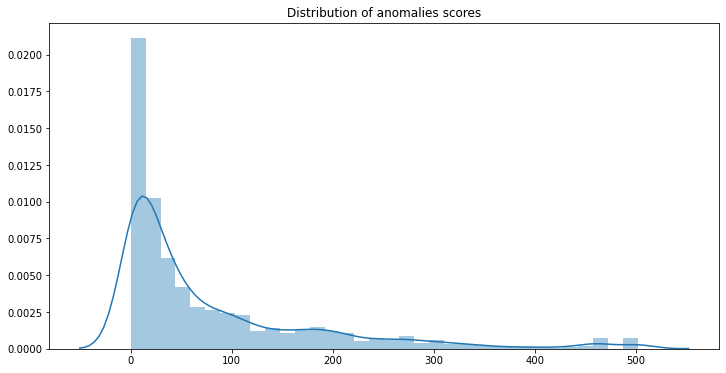

In [299]:
test_reconstructed = autoencoder.reconstruct(test_dataset)[:, :2511, :]
test_reconstructed = test_reconstructed.reshape(test_reconstructed.shape[1], test_reconstructed.shape[0], number_of_features)

scores = np.zeros(2511)
for idx in range(2511):
    scores[idx] += autoencoder.loss_fn(torch.Tensor(test_reconstructed[idx, :, :]), torch.Tensor(test_data[idx, :, :])).numpy()

plt.figure(1, figsize=(12, 6))
sns.distplot(scores)
_ = plt.title('Distribution of anomalies scores')

In [309]:
labels = np.zeros(scores.shape)
labels[scores > 250] = 1

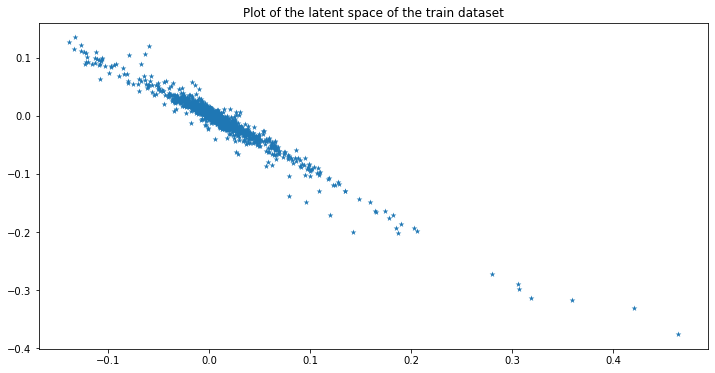

In [307]:
latent = autoencoder.transform(train_dataset)[:2511, :]

plt.figure(1, figsize=(12, 6))
plt.scatter(latent[:, 0], latent[:, 1], marker='*', linewidths=0)
_ = plt.title('Plot of the latent space of the train dataset')

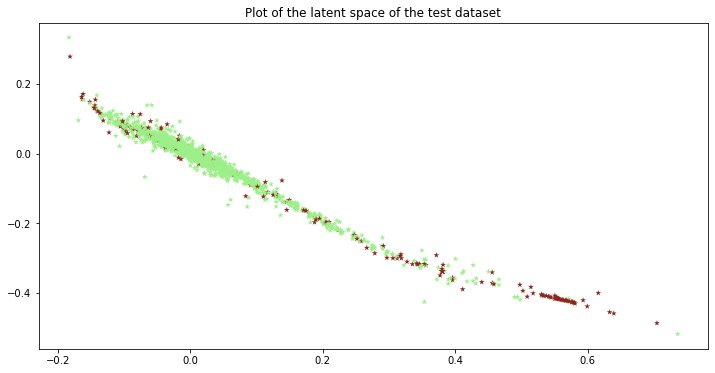

In [310]:
latent = autoencoder.transform(test_dataset)[:2511, :]

hex_colors = []
for _ in np.unique(labels):
    hex_colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))

colors = [hex_colors[int(i)] for i in labels]

plt.figure(1, figsize=(12, 6))
plt.scatter(latent[:, 0], latent[:, 1], c=colors, marker='*', linewidths=0)
_ = plt.title('Plot of the latent space of the test dataset')

In [130]:
date = str(datetime.now()).replace(' ', '_')

np.savetxt(data_path / f'submission_{date}.csv', score, fmt = '%1.6f', delimiter=',')

## Conclusion

|**Approch**                                  |         **Score**              |
| ------------------------------------------  |--------------------------------|
| Dense Autoencoder + Isolation forest        | 0.69                           |
| Convolutional Autoencoder                   | 0.72                           |
| Variational Recurent Autoencoder            | 0.76                           |